# **Adaboost Algorithm with NumPy and Sklearn**
## *For text categorization*

### Dependecies

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from imdbDataSet import *
import sklearn.metrics
import sklearn.ensemble
import sklearn.model_selection
import sklearn.tree

colours = ['#0d0d0d', '#f52a2a', '#f5bf2a', '#21c71e', '#1bdeb4', '#4287f5', '#1b24de', '#6313d4', '#c511cf', '#cf1157']

The imdbDataSet is a python file containing all the preprocessing necessary. It loads the training and testing data from the **keras imdb dataset** and splits them. We can also get our feature vector from there. Howerver, later on we still need to convert our X_train, X_test to {0, 1} based on if the word does exist in our generated feature vector.

## **Adaboost with NumPy**
- **Disclaimer** for the haters: We are not just using numpy. For the creation of the tree stumps (weak learners) we use the <i>DecisionTreeClassifier</i>, with a <i>max depth of 1</i> from the sklearn.tree package.

### **Amount of say**
The amount of say of a stump indicates its importance based on its error. A stump with a high total error will have a less important say than a stump with a lower total error. So when all weak learners are voting in the end, each one will have different impact on the final decision.

In [6]:
def amountOfSay(totalError):
    a = 0.5 * np.log((1 - totalError) / totalError)
    return a

def plotAmountOfSay(totalError, a):
    # plot the performance curve
    plt.xlabel("Error rate")
    plt.ylabel("Alpha")
    # evenly sampled error rate at 0.02 intervals
    err_rate = np.arange(0.02, 1., 0.02)
    plt.plot(err_rate, 0.5*np.log((1 - err_rate)/err_rate), '#004883')
    # plot our α
    plt.plot([totalError], [a], 'go', label="α = " + str(a))
    x_0_dotted = np.arange(-2, a+0.05, 0.05)
    y_0_dotted = np.arange(0., totalError+0.05, 0.05) if a < 2 else np.arange(0., totalError, 0.05)
    plt.plot(np.zeros(len(x_0_dotted)) + totalError, x_0_dotted, 'g--', linewidth=0.8)
    plt.plot(y_0_dotted, np.zeros(len(y_0_dotted)) + a, 'g--', linewidth=0.8)
    
    plt.legend()
    plt.show()

### Example of low stump error

Error [1]: 0.35
Amount of say [1]: 0.3095196042031118


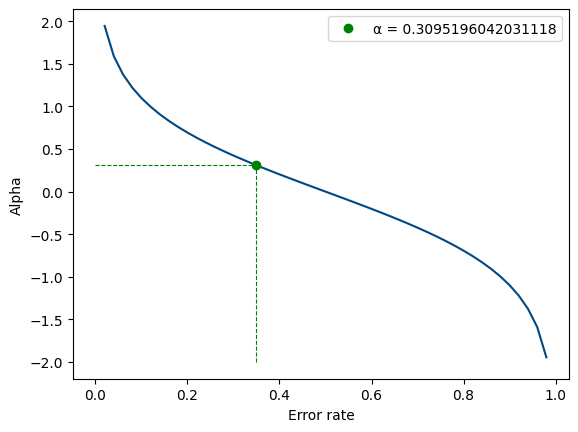

In [7]:
# low error -> high alpha
_err = 0.35
_a = amountOfSay(_err)
print("Error [1]:", _err)
print("Amount of say [1]:", _a)
plotAmountOfSay(_err, _a)

### Example of high error

Error [2]: 0.62
Amount of say [2]: -0.2447741126593529


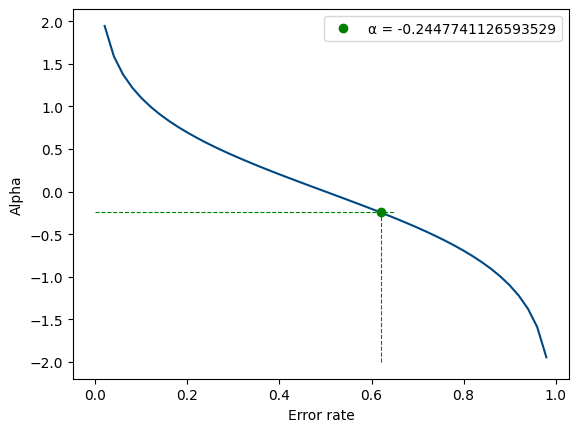

In [8]:
# high error -> low alpha
n_err = 0.62
n_a = amountOfSay(n_err)
print("Error [2]:", n_err)
print("Amount of say [2]:", n_a)
plotAmountOfSay(n_err, n_a)

### **Adaboost Classifier**
Here we create the Adaboost classifier. We can specify the *n estimators* (how many weak learners there will be made).
- **fit:** The fit method helps with the training of our model. It takes 2 args the X_train and the y_train. First of all we set the weights of each sample to be $ 1 / n $. Then for each iteration the best weak learner is picked (probably the one with the most information gain). We calculate its error and re-adjust the weights of our samples. We lower the weight of the ones that were correctly classified by the chosen stump, since we need the next stump we choose to be better at classifying those that the previous got wrong etc. Finally we calculate the amount of say of the stump.<br><br>
- **predict:** In the predict method we get the results of our classifier for some test samples (X). We first get the predictions of each stump for our X. If a weak learner predicts positive the we add to the positive array its amount of say, if it predicts negative we put it in the negative array. Finally we check which array has the biggest sum. The result is the prediction for a sample.<br><br>
- **predict_proba:** The predict proba method returns what is the probability of a sample being classified as 1 (positive).

In [9]:
class Adaboost:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        self.chosen_stumps = [] # all the hypothesis
        self.alphas = [] # amounts of say for each stump

    def fit(self, X, y):
        n = X.shape[0] # number of samples
        f = X.shape[1] # number of features

        w = [1/n for _ in range(n)] # initialize weights

        # create n n_estimators stump trees
        for m in range(self.n_estimators):
            stump = sklearn.tree.DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=w)
            self.chosen_stumps.append(stump)

            error = 1 - stump.score(X, y, w) # calculate the error of the stump
            #print("Error:", error)

            predictions = stump.predict(X) # get the stump's prediction for each of the samples

            # if the prediction for a sample is correct, lower its weight
            for i in range(n):
                if (predictions[i] == y[i]):
                    w[i] = w[i] * (error/(1 - error))
            
            w = [weight/sum(w) for weight in w] # normalize new weights

            # calculate amount of say of the stump
            a = amountOfSay(error)
            self.alphas.append(a)
            #print("Amount of say:", a)
            
    def predict(self, X):
        stump_predictions = np.zeros((self.n_estimators, X.shape[0])) # create the shape of the array
        for s in range(len(self.chosen_stumps)):
            stump = self.chosen_stumps[s]
            prediction = stump.predict(X) # for each stump get its predictions for all the samples
            stump_predictions[s] = prediction # add them to the array
            
        final_preds = []
        # for each sample
        for i in range(len(stump_predictions.T)):
            positives = []
            negatives = []
            # for each of the stumps
            for j in range(len(stump_predictions)):
                if (stump_predictions.T[i][j] == 0): # if it predicts negative add its α to the negatives
                    negatives.append(self.alphas[j])
                else:                                # if it predicts positive add its α to the positives
                    positives.append(self.alphas[j])
            if (sum(positives) > sum(negatives)): # check which one has the bigger total amount of say and append to final predictions
                final_preds.append(1)
            else:
                final_preds.append(0)

        return final_preds
    
    def predict_proba(self, X):
        stump_probas = np.array([stump.predict_proba(X)[:, 1] for stump in self.chosen_stumps])
        # print(stump_probas)
        final_probas = []
        for i in range(len(stump_probas.T)):
            _mul = np.multiply(stump_probas.T[i], self.alphas)
            _sum = np.sum(_mul)
            _sum = _sum/sum(self.alphas)
            final_probas.append(_sum)

        return final_probas


### **Training**
In this phase we will train different instances of our algorithm. Here we also need to do some preprocessing for our data. Before adding them to the fit function of the Adaboost classifier we need to shape them correctly. The way we do that is based on the feature vector we get. This is how it works:
- We get each row of the sample
- For every word in the row we check if it exists in the feature vector.
- If it does then get the index of that word in the feature vector and mark as 1 (exists) the word in the row
#
*(We do that for both the X_train and X_test)*
#
Now all that is left to do is fit and predict.

In [28]:
imdb = IMDB()

def runTest(N=250, M=1000, N_ESTIMATORS=50, TRAIN=1000, TESTS=1000):
    res = imdb.getTrainingData(1, 2, 3, N, M, 2000)

    # get feature vector
    features = imdb.getFeatureVector(N, M)

    # get values of each feature for n movie reviews
    n = TRAIN
    X_train = np.zeros((n, len(features)))
    y_train = list()
    X_test = np.zeros((n, len(features)))
    y_test = list()
    # for the first n reviews
    for i in range(n):
        x_i = imdb.getXtrain(i)
        xt_i = imdb.getXtest(i)
        y_train.append(imdb.getYtrain(i))
        y_test.append(imdb.getYtest(i))
        # for word index in x_train
        for wi in x_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_train[i][j] = 1
        for wi in xt_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_test[i][j] = 1

    X_test = X_test[:TESTS]
    y_test = y_test[:TESTS]

    ab = Adaboost(N_ESTIMATORS)
    ab.fit(X_train, y_train)

    y_pred_train = ab.predict(X_train[:TESTS])
    y_pred_test = ab.predict(X_test)

    return y_pred_train, y_pred_test, y_train, y_test

Now we train *[Instances]* different models. In the *runTest* function the parameters are the following:
- **N: *(int)* Amount of words to skip in our vocabulary**<br>This is important since the first words in our vocabulary will be articles, prepositions etc. where we can't extract much information from these.<br>*Default is 250*<br><br>
- **M: *(int)* Amount of words to include in our vocabulary**<br>These are the words that we will take into consideration and form our feature vector out of.<br>i.e. If we have a *N=250* and a *M=1000*, the the feature vector will be the range of (251, 1251) words.<br>*Default is 1000*<br><br>
- **N_ESTIMATORS: *(int)* How many stump trees to create**<br>*Default is 50*<br><br>
- **TRAIN: *(int)* How many samples to train on**<br>*Default is 1000*<br><br>
- **TEST: *(int)* How many samples to test on**<br>*Default is 1000*

In [39]:
INSTANCES = 10
x = []
my_ada_train = []
my_ada_test = []
my_ada_precision_train = []
my_ada_precision_test = []
my_ada_recall_train = []
my_ada_recall_test = []
my_ada_f1_train = []
my_ada_f1_test = []

for i in range(INSTANCES):
    x.append(1000*(i+1))
    y_pred_train, y_pred_test, y_train, y_test = runTest(250, 1000, 100, 1000*(i+1), 10000)

    ada_train = sklearn.metrics.accuracy_score(y_train, y_pred_train)
    ada_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
    ada_precision_train = sklearn.metrics.precision_score(y_true=y_train, y_pred=y_pred_train)
    ada_precision_test = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_pred_test)
    ada_recall_train = sklearn.metrics.recall_score(y_true=y_train, y_pred=y_pred_train)
    ada_recall_test = sklearn.metrics.recall_score(y_true=y_test, y_pred=y_pred_test)
    ada_f1_train = sklearn.metrics.f1_score(y_true=y_train, y_pred=y_pred_train)
    ada_f1_test = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred_test)

    my_ada_train.append(ada_train)
    my_ada_test.append(ada_test)
    my_ada_precision_train.append(ada_precision_train)
    my_ada_precision_test.append(ada_precision_test)
    my_ada_recall_train.append(ada_recall_train)
    my_ada_recall_test.append(ada_recall_test)
    my_ada_f1_train.append(ada_f1_train)
    my_ada_f1_test.append(ada_f1_test)

print("Train\n-----------------------------------------------")
print("Accuracy:", my_ada_train)
print("Precision:", my_ada_precision_train)
print("Recall:", my_ada_recall_train)
print("F1:", my_ada_f1_train)

print("\nTest\n-----------------------------------------------")
print("Accuracy:", my_ada_test)
print("Precision:", my_ada_precision_test)
print("Recall:", my_ada_recall_test)
print("F1:", my_ada_f1_test)

Train
-----------------------------------------------
Accuracy: [0.809, 0.769, 0.7713333333333333, 0.767, 0.7574, 0.7655, 0.7578571428571429, 0.75125, 0.7588888888888888, 0.7675]
Precision: [0.7589743589743589, 0.72, 0.7369878183831672, 0.728099173553719, 0.7111181501425404, 0.7267217630853995, 0.7212410501193317, 0.7096906371645154, 0.7162629757785467, 0.7348484848484849]
Recall: [0.8987854251012146, 0.8973607038123167, 0.8631647211413749, 0.8654223968565815, 0.8817753338570307, 0.8640681297084835, 0.8515074668920822, 0.858062918008422, 0.8653465346534653, 0.844646744508213]
F1: [0.8229842446709917, 0.7989556135770236, 0.7951015531660695, 0.7908438061041292, 0.7873049272312818, 0.7894658087685172, 0.7809794547099107, 0.7768557972639604, 0.783778397768035, 0.7859313138753338]

Test
-----------------------------------------------
Accuracy: [0.747, 0.734, 0.741, 0.7465, 0.74, 0.742, 0.7448571428571429, 0.741875, 0.742, 0.7531]
Precision: [0.695575221238938, 0.6698950766747377, 0.68444693

In [76]:
import csv

temp_train = []
temp_train.append(my_ada_train)
temp_train.append(my_ada_recall_train)
temp_train.append(my_ada_precision_train)
temp_train.append(my_ada_f1_train)
temp_train = np.array(temp_train)
print(temp_train.T)

temp_test = []
temp_test.append(my_ada_test)
temp_test.append(my_ada_recall_test)
temp_test.append(my_ada_precision_test)
temp_test.append(my_ada_f1_test)
temp_test = np.array(temp_test)
print(temp_test.T)

filename = "my_adaboost.csv"
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(temp_train.T)
    csvwriter.writerow("")
    csvwriter.writerows(temp_test.T)

[[0.809      0.89878543 0.75897436 0.82298424]
 [0.769      0.8973607  0.72       0.79895561]
 [0.77133333 0.86316472 0.73698782 0.79510155]
 [0.767      0.8654224  0.72809917 0.79084381]
 [0.7574     0.88177533 0.71111815 0.78730493]
 [0.7655     0.86406813 0.72672176 0.78946581]
 [0.75785714 0.85150747 0.72124105 0.78097945]
 [0.75125    0.85806292 0.70969064 0.7768558 ]
 [0.75888889 0.86534653 0.71626298 0.7837784 ]
 [0.7675     0.84464674 0.73484848 0.78593131]]
[[0.747      0.82911392 0.69557522 0.75649663]
 [0.734      0.87093389 0.66989508 0.75729927]
 [0.741      0.85006974 0.68444694 0.75832037]
 [0.7465     0.86210472 0.68975529 0.76635945]
 [0.74       0.87278716 0.68145291 0.76534296]
 [0.742      0.85380711 0.69332234 0.76524113]
 [0.74485714 0.84450247 0.69959144 0.76524711]
 [0.741875   0.85526316 0.69361789 0.76600567]
 [0.742      0.85393258 0.69444444 0.7659746 ]
 [0.7531     0.83732154 0.71497253 0.77132537]]


### **Plotting**
Now we plot diagrams of our results above.
- Accuracy Train, Accuracy Test
- Precision, Recall
- F1

### Accuracy

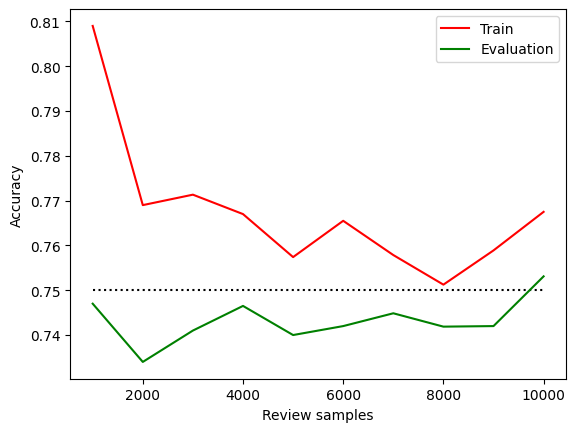

In [56]:
# plot the accuracy curve
plt.xlabel("Review samples")
plt.ylabel("Accuracy")

plt.plot(x, [0.75] * len(x), color='black', linestyle='dotted')
plt.plot(x, my_ada_train, 'red', label="Train")
plt.plot(x, my_ada_test, 'green', label="Evaluation")

plt.legend()
plt.show()

### Precision-Recall

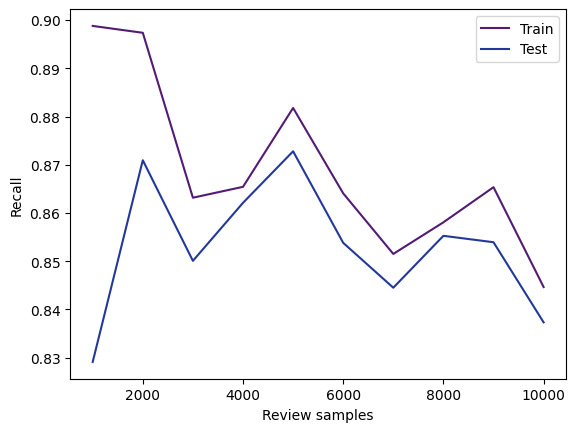

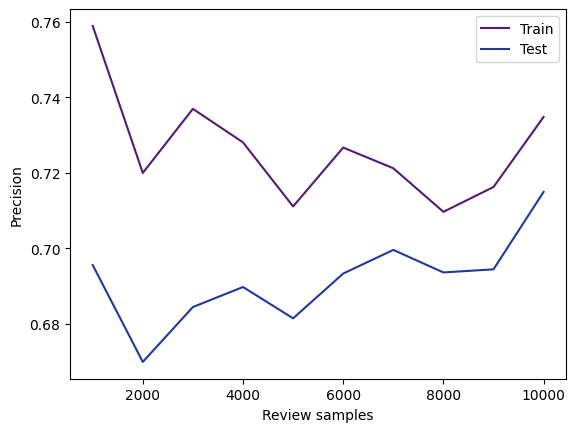

In [52]:
# plot the recall curve
plt.xlabel("Review samples")
plt.ylabel("Recall")

plt.plot(x, my_ada_recall_train, color='#541b75', label="Train")
plt.plot(x, my_ada_recall_test, color='#233999', label="Test")

plt.legend()
plt.show()

# plot the precision curve
plt.xlabel("Review samples")
plt.ylabel("Precision")

plt.plot(x, my_ada_precision_train, color='#541b75', label="Train")
plt.plot(x, my_ada_precision_test, color='#233999', label="Test")

plt.legend()
plt.show()

### F1 score

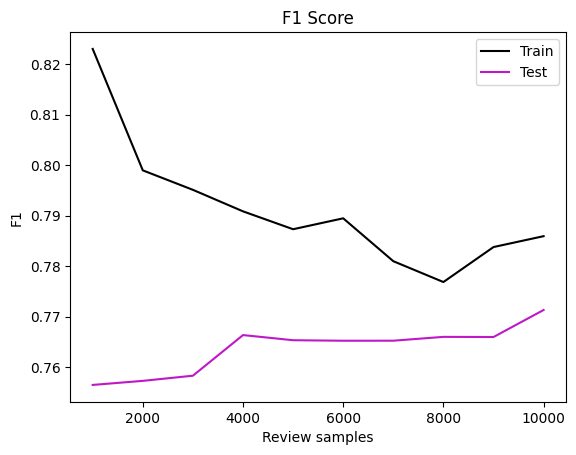

In [53]:
# plot the f1 score
plt.title("F1 Score")
plt.xlabel("Review samples")
plt.ylabel("F1")

plt.plot(x, my_ada_f1_train, 'black', label="Train")
plt.plot(x, my_ada_f1_test, '#be18c7', label="Test")

plt.legend()
plt.show()

## **Adaboost with Sklearn**

Here we do everything that we did above but instead of using our Adaboost classifier, we use *sklearn.ensemble.AdaboostClassifier*.

### **Training**

In [59]:
# Sklearn Adaboost
imdb = IMDB()

def runTestSK(N=250, M=1000, Train=1000, TESTS=1000):
    res = imdb.getTrainingData(1, 2, 3, N, M, 2000)
    
    # get feature vector
    features = imdb.getFeatureVector(N, M)

    # get values of each feature for n movie reviews
    n = Train
    X_train = np.zeros((n, len(features)))
    y_train = list()
    X_test = np.zeros((n, len(features)))
    y_test = list()
    # for the first n reviews
    for i in range(n):
        x_i = imdb.getXtrain(i)
        xt_i = imdb.getXtest(i)
        y_train.append(imdb.getYtrain(i))
        y_test.append(imdb.getYtest(i))
        # for word index in x_train
        for wi in x_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_train[i][j] = 1
        for wi in xt_i:
            if wi == 2:
                continue
            elif (wi in features):
                j = features.index(wi)
                X_test[i][j] = 1

    ab = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)
    ab.fit(X_train, y_train)

    y_train_pred = ab.predict(X_train)
    y_test_pred = ab.predict(X_test)

    return y_train_pred, y_test_pred, y_train, y_test

Run Instances.

In [63]:
# run Test SK
xs = []
for i in range(INSTANCES):
    xs.append(1000*(i+1))

trains_accuracy = []
tests_accuracy = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1s = []
test_f1s = []

for i in range(INSTANCES):
    y_train_pred, y_test_pred, y_train, y_test = runTestSK(Train=1000*(i+1))

    ada_train = sklearn.metrics.accuracy_score(y_train, y_train_pred)
    ada_test = sklearn.metrics.accuracy_score(y_test, y_test_pred)
    ada_precision_train = sklearn.metrics.precision_score(y_true=y_train, y_pred=y_train_pred)
    ada_precision_test = sklearn.metrics.precision_score(y_true=y_test, y_pred=y_test_pred)
    ada_recall_train = sklearn.metrics.recall_score(y_true=y_train, y_pred=y_train_pred)
    ada_recall_test = sklearn.metrics.recall_score(y_true=y_test, y_pred=y_test_pred)
    ada_f1_train = sklearn.metrics.f1_score(y_true=y_train, y_pred=y_train_pred)
    ada_f1 = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_test_pred)

    trains_accuracy.append(ada_train)
    tests_accuracy.append(ada_test)
    train_precisions.append(ada_precision_train)
    test_precisions.append(ada_precision_test)
    train_recalls.append(ada_recall_train)
    test_recalls.append(ada_recall_test)
    train_f1s.append(ada_f1_train)
    test_f1s.append(ada_f1_test)

print("Train\n-----------------------------------------------")
print("Accuracy:", trains_accuracy)
print("Precision:", train_precisions)
print("Recall:", train_recalls)
print("F1:", train_f1s)

print("Test\n-----------------------------------------------")
print("Accuracy:", tests_accuracy)
print("Precision:", test_precisions)
print("Recall:", test_recalls)
print("F1:", test_f1s)


Train
-----------------------------------------------
Accuracy: [0.899, 0.836, 0.816, 0.811, 0.816, 0.8145, 0.8084285714285714, 0.81125, 0.8101111111111111, 0.8105]
Precision: [0.8786127167630058, 0.8410206084396468, 0.8189432989690721, 0.7938475665748393, 0.7975841874084919, 0.7964547677261614, 0.789308176100629, 0.7918687918687919, 0.7909314731226919, 0.7937127976190477]
Recall: [0.9230769230769231, 0.8377321603128055, 0.8242542153047989, 0.8492141453831041, 0.8558523173605656, 0.8535866360956437, 0.8486897717666948, 0.8491454050037156, 0.8481848184818482, 0.8444488422719176]
F1: [0.9002961500493584, 0.8393731635651323, 0.821590174531351, 0.8205980066445183, 0.8256915498294809, 0.8240316205533598, 0.8179226069246437, 0.8195075304805164, 0.8185582333581061, 0.8182951385559497]
Test
-----------------------------------------------
Accuracy: [0.751, 0.7635, 0.775, 0.78825, 0.7852, 0.7876666666666666, 0.793, 0.79525, 0.7947777777777778, 0.7926]
Precision: [0.7210216110019646, 0.7564102564

### **Plotting**

### Accuracy

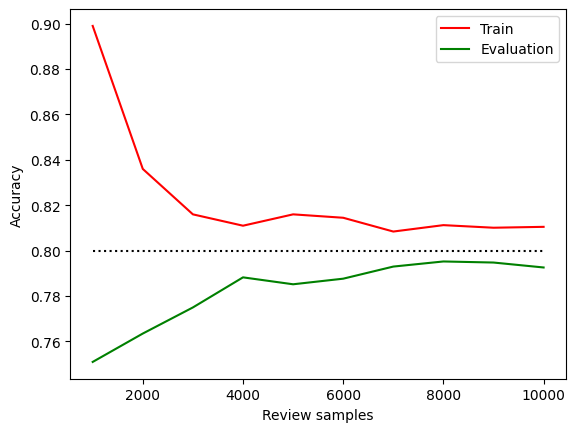

In [64]:
# plot the accuracy curve
plt.xlabel("Review samples")
plt.ylabel("Accuracy")

plt.plot(xs, [0.8]*len(xs), color='black', linestyle='dotted')
plt.plot(xs, trains_accuracy, 'red', label="Train")
plt.plot(xs, tests_accuracy, 'green', label="Evaluation")

plt.legend()
plt.show()

### Precision-Recall

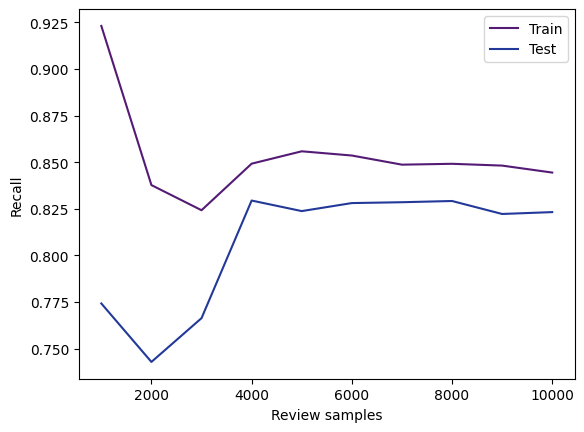

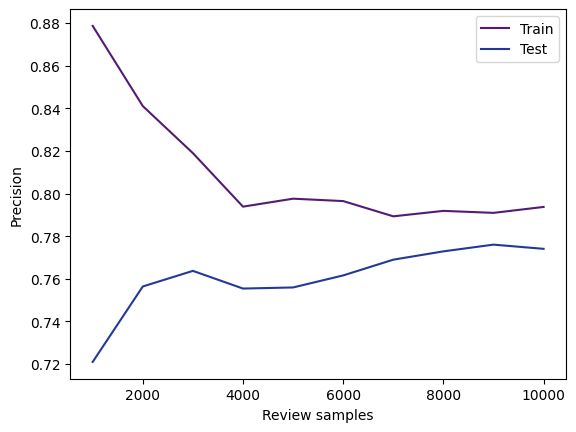

In [65]:
# plot the recall curve
plt.xlabel("Review samples")
plt.ylabel("Recall")

plt.plot(xs, train_recalls, color='#541b75', label="Train")
plt.plot(xs, test_recalls, color='#233999', label="Test")

plt.legend()
plt.show()

# plot the precision curve
plt.xlabel("Review samples")
plt.ylabel("Precision")

plt.plot(xs, train_precisions, color='#541b75', label="Train")
plt.plot(xs, test_precisions, color='#233999', label="Test")

plt.legend()
plt.show()

### F1 score

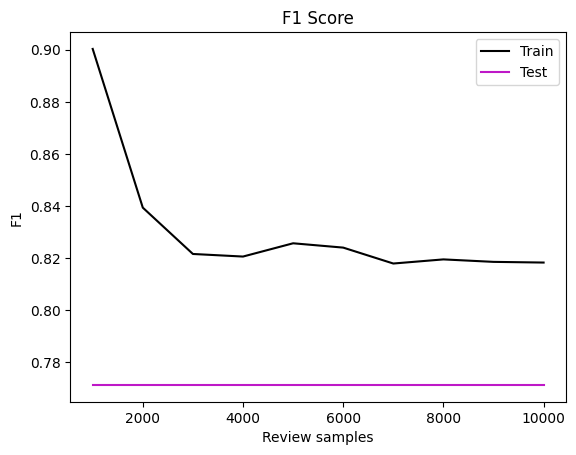

In [66]:
# plot the f1 score
plt.title("F1 Score")
plt.xlabel("Review samples")
plt.ylabel("F1")

plt.plot(xs, train_f1s, 'black', label="Train")
plt.plot(xs, test_f1s, '#be18c7', label="Test")

plt.legend()
plt.show()

In [79]:
temp_train = []
temp_train.append(trains_accuracy)
temp_train.append(train_recalls)
temp_train.append(train_precisions)
temp_train.append(train_f1s)
temp_train = np.array(temp_train)
print(temp_train.T)

temp_test = []
temp_test.append(tests_accuracy)
temp_test.append(test_recalls)
temp_test.append(test_precisions)
temp_test.append(test_f1s)
temp_test = np.array(temp_test)
print(temp_test.T)

filename = "sk_adaboost.csv"
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(temp_train.T)
    csvwriter.writerow("")
    csvwriter.writerows(temp_test.T)

[[0.899      0.92307692 0.87861272 0.90029615]
 [0.836      0.83773216 0.84102061 0.83937316]
 [0.816      0.82425422 0.8189433  0.82159017]
 [0.811      0.84921415 0.79384757 0.82059801]
 [0.816      0.85585232 0.79758419 0.82569155]
 [0.8145     0.85358664 0.79645477 0.82403162]
 [0.80842857 0.84868977 0.78930818 0.81792261]
 [0.81125    0.84914541 0.79186879 0.81950753]
 [0.81011111 0.84818482 0.79093147 0.81855823]
 [0.8105     0.84444884 0.7937128  0.81829514]]
[[0.751      0.7742616  0.72102161 0.77132537]
 [0.7635     0.7429171  0.75641026 0.77132537]
 [0.775      0.76638773 0.76372481 0.77132537]
 [0.78825    0.82944531 0.75542965 0.77132537]
 [0.7852     0.8237958  0.75595013 0.77132537]
 [0.78766667 0.82808799 0.76159353 0.77132537]
 [0.793      0.82854656 0.76898223 0.77132537]
 [0.79525    0.8292004  0.77287736 0.77132537]
 [0.79477778 0.82224719 0.77603393 0.77132537]
 [0.7926     0.82324553 0.77405937 0.77132537]]


In [48]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from keras import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.layers import TextVectorization

In [49]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the

In [50]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback])

model.summary()

Epoch 1/15
20/20 [==============================] - 3s 151ms/step - loss: 0.6923 - accuracy: 0.5028 - val_loss: 0.6907 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 2s 92ms/step - loss: 0.6886 - accuracy: 0.5028 - val_loss: 0.6856 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 2s 90ms/step - loss: 0.6819 - accuracy: 0.5028 - val_loss: 0.6770 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 2s 88ms/step - loss: 0.6708 - accuracy: 0.5028 - val_loss: 0.6635 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 2s 89ms/step - loss: 0.6543 - accuracy: 0.5035 - val_loss: 0.6450 - val_accuracy: 0.4940
Epoch 6/15
20/20 [==============================] - 2s 90ms/step - loss: 0.6318 - accuracy: 0.5354 - val_loss: 0.6217 - val_accuracy: 0.5500
Epoch 7/15
20/20 [==============================] - 2s 88ms/step - loss: 0.6041 - accuracy: 0.6100 - val_loss: 0.5947 - val_accuracy: 0.6208
Epoch 8/15
2